In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1-FH5h2JCQ1h6DYivh9b0lgUNFwGt1s4r
!unzip data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-FH5h2JCQ1h6DYivh9b0lgUNFwGt1s4r
From (redirected): https://drive.google.com/uc?id=1-FH5h2JCQ1h6DYivh9b0lgUNFwGt1s4r&confirm=t&uuid=d806f505-b4e8-4978-bd74-ced4f5e3aa34
To: /content/data.zip
100% 629M/629M [00:06<00:00, 90.6MB/s]
Archive:  data.zip
   creating: data/
   creating: data/image_3/
  inflating: data/image_3/000058_11.png  
  inflating: data/image_3/000170_11.png  
  inflating: data/image_3/000154_11.png  
  inflating: data/image_3/000127_10.png  
  inflating: data/image_3/000085_11.png  
  inflating: data/image_3/000122_10.png  
  inflating: data/image_3/000020_11.png  
  inflating: data/image_3/000102_10.png  
  inflating: data/image_3/000160_11.png  
  inflating: data/image_3/000087_10.png  


In [ ]:
%cd /content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution

/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution


In [ ]:
import tensorflow as tf
import os

print(tf.__version__)

2.17.1


In [ ]:
data_train = '/content/data/image_2/*.png'
data_test = '/content/data/image_3/*.png'
checkpoint_dir = '/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/checkpoint/'
buffer_size = 20
batch_size = 1
img_height = 256
img_width = 1024
low_height = 64
low_width = 256
epochs = 150

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SubPixel(layers.Layer):
    def __init__(self, upscale_factor, channels, activation=None):
        super(SubPixel, self).__init__()
        self.upscale_factor = upscale_factor
        self.channels = channels
        self.activation = activation

    def __call__(self, inputs):
        x = layers.Conv2D(self.channels*(self.upscale_factor ** 2), 3, padding="same",
                            activation=self.activation, kernel_initializer="Orthogonal")(inputs)
        outputs = tf.nn.depth_to_space(x, self.upscale_factor)
        return outputs

def extract_first_features(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                        strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def downsample_sr(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=1, padding='same', use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())

    return result

def upsample_sr(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                            strides=2, padding='same', use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.LeakyReLU())

    return result

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models



def DiscriminatorDenoise():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    tar = tf.keras.layers.Input(shape=[low_height, low_width, 3])
    x = tf.keras.layers.concatenate([inp, tar])

    x = downsample(filters=64,  size=4, apply_batchnorm=False)(x)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)

    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)

    model = models.Model(inputs=[inp,tar], outputs=x)

    return model

def DiscriminatorSR():
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator

    inp = tf.keras.layers.Input(shape=[img_height, img_width, 3])

    x = downsample(filters=64,  size=4, apply_batchnorm=False)(inp)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)

    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                            strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                            strides=1, use_bias=False)(x)

    model = models.Model(inputs=inp, outputs=x)

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


def UNet_process(x):
    """
    feature image input -> noise free image

    """
    down_stack = [
        downsample(filters=64, size=4, apply_batchnorm=False),
        downsample(filters=256, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
    ]

    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=256, size=4, apply_dropout=True),
        upsample(filters=64, size=4, apply_dropout=False),
    ]

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return x

def Generator():
    """
    model denoise and super resolution ((x4 size))

    """
    inputs = layers.Input(shape=(low_height, low_width, 3))
    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(inputs)
    x = UNet_process(x)
    fake_lr = x

    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)

    x = upsample_sr(filters=128, size=4, apply_dropout=False)(x)

    x = downsample_sr(filters=128, size=3, apply_batchnorm=True)(x)

    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                            strides=2, padding='same', activation='tanh')

    fake_hr = last(x)

    model = models.Model(inputs=inputs, outputs=[fake_lr, fake_hr])

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


def discriminator_loss(disc_real_output, disc_generated_output):

    loss_dsic_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.03)

    real_los = loss_dsic_object(tf.ones_like(disc_real_output), disc_real_output)

    fake_los = loss_dsic_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_loss = real_los + fake_los

    return total_loss

def generator_denoise_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss

def generator_sr_loss(disc_generated_output, gen_output, target):

    bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    LAMBDA = 40

    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt


def load(image_path):
    """
    Parameters
    ----------
    image_path : string

    Returns
    -------
    image_lr: tf.Tensor (tf.float32) input low resolution and noise
    target_lr: tf.Tensor (tf.float32) target low resolution and not noise
    target_hr: tf.Tensor (tf.float32) target high resolution
    """

    # read file and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)

    # resize image_lr, target_lr with low_width and low_height
    image_lr = tf.image.resize(image, size=(low_height, low_width))
    target_lr = tf.image.resize(image, size=(low_height, low_width))

    # resize target_hr IMG_WIDTH and IMG_HEIGHT
    target_hr = tf.image.resize(image, size=(img_height, img_width))

    # create noise matrix has size with low_width and low_height
    noise_per = 0.20
    noise = tf.random.uniform(shape=(low_height, low_width, 3), minval=1-noise_per, maxval=1+noise_per)

    # Convert image to float32 tensors
    image_lr = tf.cast(image_lr, dtype=tf.float32)
    target_lr = tf.cast(target_lr, dtype=tf.float32)
    target_hr = tf.cast(target_hr, dtype=tf.float32)

    # image_lr multiply noise matrix -> noise image
    image_lr = image_lr*noise
    image_lr = tf.clip_by_value(image_lr, 0, 255)

    return image_lr, target_lr, target_hr

def normalize(image_lr, target_lr, target_hr):
    """
    normalizing the images to [-1, 1]

    """
    image_lr  = (image_lr/127.5) - 1
    target_lr = (target_lr/127.5) - 1
    target_hr = (target_hr/127.5) - 1

    return image_lr, target_lr, target_hr

#@tf.function()
def random_jitter(image_lr, target_lr, target_hr):
    """
    There is a 50% chance of flipping the image from left to right

    """
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        image_lr  = tf.image.flip_left_right(image_lr)
        target_lr  = tf.image.flip_left_right(target_lr)
        target_hr  = tf.image.flip_left_right(target_hr)

    return image_lr, target_lr, target_hr

def load_image_train(image_path):
    """
    load image, random_jitter and normalize image

    """
    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = random_jitter(image_lr, target_lr, target_hr)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr

def load_image_test(image_path):
    """
    load image and normalize image

    """

    image_lr, target_lr, target_hr = load(image_path)

    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr


def evaluate(model, epoch, data):
    psnr_mean = 0.0
    for image_lr, target_lr, target_hr in data:
        fake_lr, fake_hr = model(image_lr, training=False)
        psnr_b = tf.image.psnr(fake_hr, target_hr, max_val=1.0)
        psnr_mean = tf.math.reduce_mean(psnr_b)

#     psnr_mean = psnr_mean/10.0
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch)
    return psnr_mean


def generate_images(model, image_lr, target_sr, is_fake_lr=False):
    fake_lr, fake_hr = model([image_lr], training=False)
    if is_fake_lr:
        display_list = [image_lr[0], fake_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Denoise', 'Real', 'Generated']
        plt.figure(figsize=(25,30))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
        display_list = [image_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Real', 'Generated']
        plt.figure(figsize=(25,30))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.show()

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(data_train)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(data_test)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

generator = Generator()
discriminator1 = DiscriminatorDenoise()
discriminator2 = DiscriminatorSR()

generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)

checkpoint_dir = checkpoint_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator1_optimizer=discriminator1_optimizer,
                                discriminator2_optimizer=discriminator2_optimizer,
                                generator=generator,
                                discriminator1=discriminator1,
                                discriminator2=discriminator2)

In [ ]:
@tf.function
def train_step(image_lr, target_lr, target_hr):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:

        fake_lr, fake_hr = generator(image_lr, training=True)

        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)

        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)

        total_lr_loss, gan_lr_loss, l1_lr_loss = generator_denoise_loss(disc_lr_generated_output, fake_lr, target_lr)
        total_hr_loss, gan_hr_loss, l1_hr_loss = generator_sr_loss(disc_hr_generated_output, fake_hr, target_hr)

        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)

        gan_loss = gan_lr_loss + gan_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss

        total_gen_loss = total_lr_loss + total_hr_loss

    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_gradients = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_gradients = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_gradients, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_gradients, discriminator2.trainable_variables))

    return gan_loss, l1_loss, disc_loss

def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):

        for image_lr, target_lr, target_hr in train_ds:
            gan_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)

        psnr = evaluate(generator, epoch, test_ds)
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr

            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        print('epoch {}  gan_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, l1_loss, disc_loss))


-------- psnr:  6.996175    ----- epoch:  0


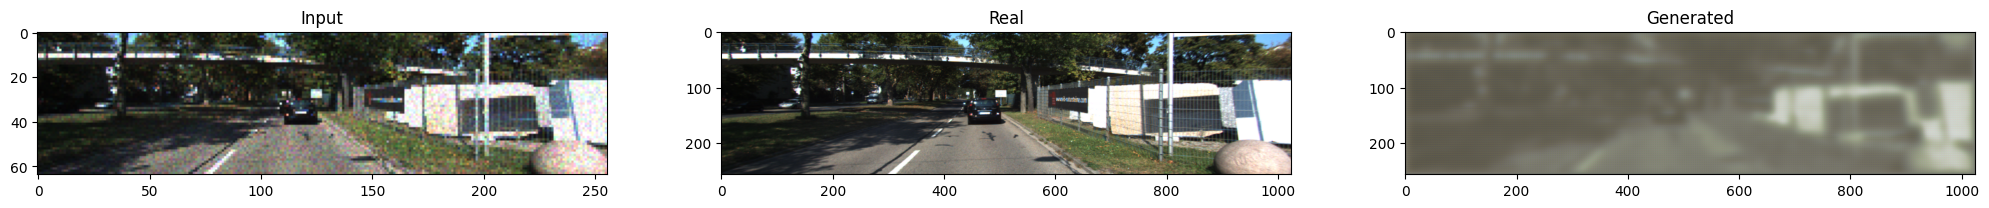

epoch 0  gan_loss: 1.6193432807922363  l1_loss: 0.40309685468673706  disc_loss: 2.6621487140655518
-------- psnr:  15.079432    ----- epoch:  1


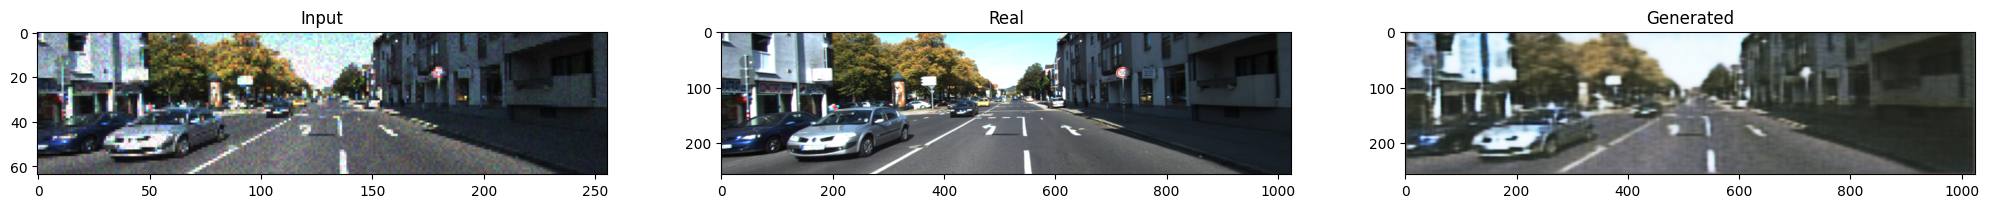

epoch 1  gan_loss: 1.1941181421279907  l1_loss: 0.23249787092208862  disc_loss: 2.8486218452453613
-------- psnr:  15.041082    ----- epoch:  2
epoch 2  gan_loss: 1.4026176929473877  l1_loss: 0.2649046778678894  disc_loss: 2.7731876373291016
-------- psnr:  15.709941    ----- epoch:  3


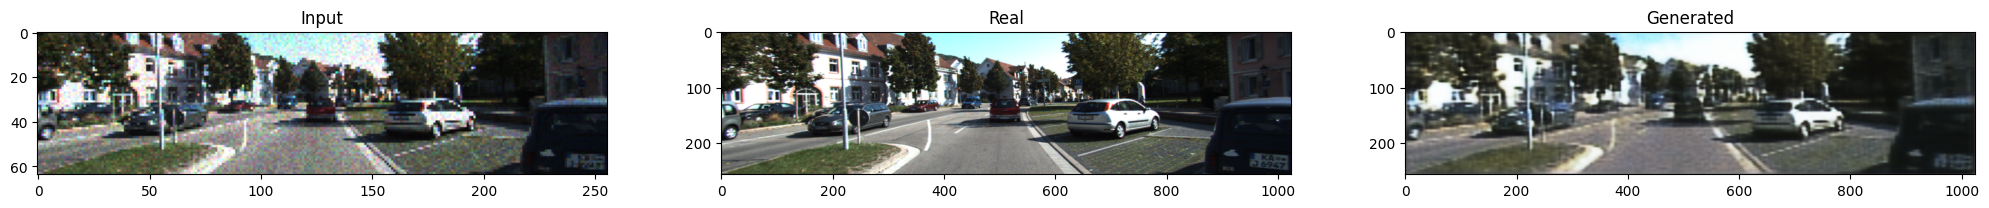

epoch 3  gan_loss: 1.4467016458511353  l1_loss: 0.1983460932970047  disc_loss: 2.8126022815704346
-------- psnr:  14.246403    ----- epoch:  4
epoch 4  gan_loss: 1.3952492475509644  l1_loss: 0.32496377825737  disc_loss: 2.76747465133667
-------- psnr:  13.534877    ----- epoch:  5
epoch 5  gan_loss: 1.3446965217590332  l1_loss: 0.3526531457901001  disc_loss: 2.753782272338867
-------- psnr:  14.783863    ----- epoch:  6
epoch 6  gan_loss: 1.389737844467163  l1_loss: 0.2593010663986206  disc_loss: 2.7613630294799805
-------- psnr:  14.582126    ----- epoch:  7
epoch 7  gan_loss: 1.523714303970337  l1_loss: 0.1735990047454834  disc_loss: 2.794154644012451
-------- psnr:  6.8606586    ----- epoch:  8
epoch 8  gan_loss: 3.0544421672821045  l1_loss: 0.22243961691856384  disc_loss: 3.881070852279663
-------- psnr:  14.409979    ----- epoch:  9
epoch 9  gan_loss: 1.4076710939407349  l1_loss: 0.20961333811283112  disc_loss: 2.7857532501220703
-------- psnr:  13.642131    ----- epoch:  10
epoch

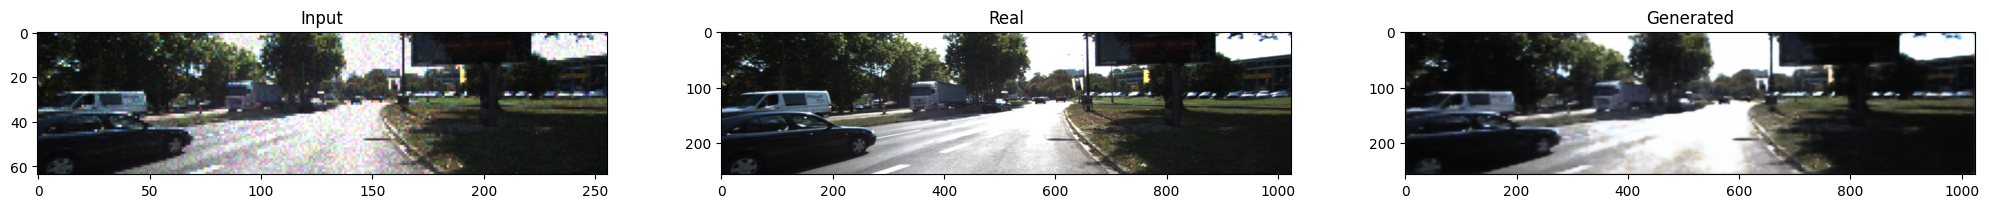

epoch 16  gan_loss: 1.4038515090942383  l1_loss: 0.17878293991088867  disc_loss: 2.762782573699951
-------- psnr:  14.167039    ----- epoch:  17
epoch 17  gan_loss: 1.3293766975402832  l1_loss: 0.2484988272190094  disc_loss: 2.7626664638519287
-------- psnr:  15.552754    ----- epoch:  18
epoch 18  gan_loss: 1.4076288938522339  l1_loss: 0.18332961201667786  disc_loss: 2.765939950942993
-------- psnr:  14.169222    ----- epoch:  19
epoch 19  gan_loss: 1.384174108505249  l1_loss: 0.1870047152042389  disc_loss: 2.7664685249328613
-------- psnr:  15.210616    ----- epoch:  20
epoch 20  gan_loss: 1.4193241596221924  l1_loss: 0.19119249284267426  disc_loss: 2.7685635089874268
-------- psnr:  15.38015    ----- epoch:  21
epoch 21  gan_loss: 1.3898097276687622  l1_loss: 0.12970127165317535  disc_loss: 2.7731375694274902
-------- psnr:  17.630695    ----- epoch:  22
epoch 22  gan_loss: 1.3778643608093262  l1_loss: 0.19614125788211823  disc_loss: 2.7736573219299316
-------- psnr:  16.973633    -

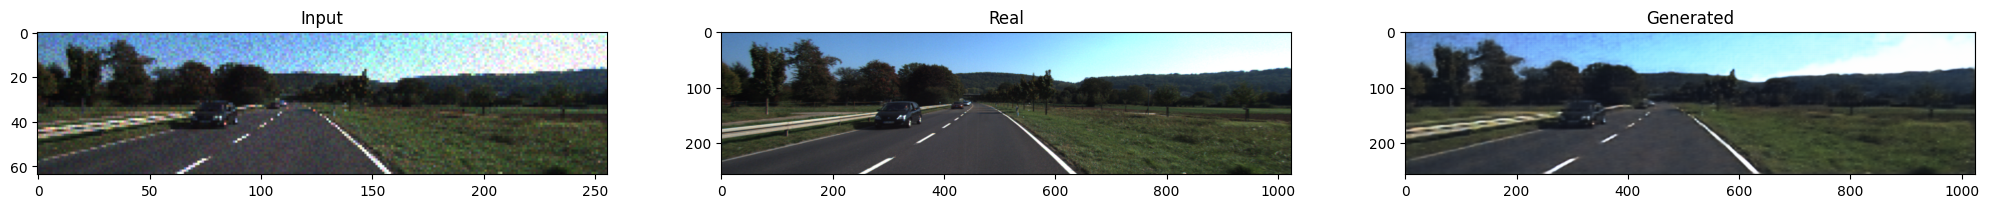

epoch 49  gan_loss: 1.3643057346343994  l1_loss: 0.16685527563095093  disc_loss: 2.7783093452453613
-------- psnr:  16.548973    ----- epoch:  50
epoch 50  gan_loss: 1.4697362184524536  l1_loss: 0.20194979012012482  disc_loss: 2.65570068359375
-------- psnr:  16.186628    ----- epoch:  51
epoch 51  gan_loss: 1.4658923149108887  l1_loss: 0.1399700939655304  disc_loss: 2.659566879272461
-------- psnr:  16.163824    ----- epoch:  52
epoch 52  gan_loss: 1.3712294101715088  l1_loss: 0.16930580139160156  disc_loss: 2.8274714946746826
-------- psnr:  16.73558    ----- epoch:  53
epoch 53  gan_loss: 1.5288488864898682  l1_loss: 0.16275513172149658  disc_loss: 2.7434792518615723
-------- psnr:  15.82921    ----- epoch:  54
epoch 54  gan_loss: 1.612928867340088  l1_loss: 0.15391825139522552  disc_loss: 3.109536647796631
-------- psnr:  17.124735    ----- epoch:  55
epoch 55  gan_loss: 1.3847291469573975  l1_loss: 0.13626034557819366  disc_loss: 2.758854866027832
-------- psnr:  15.142644    ----

In [ ]:
epochs = 120
fit(train_dataset, epochs, test_dataset)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

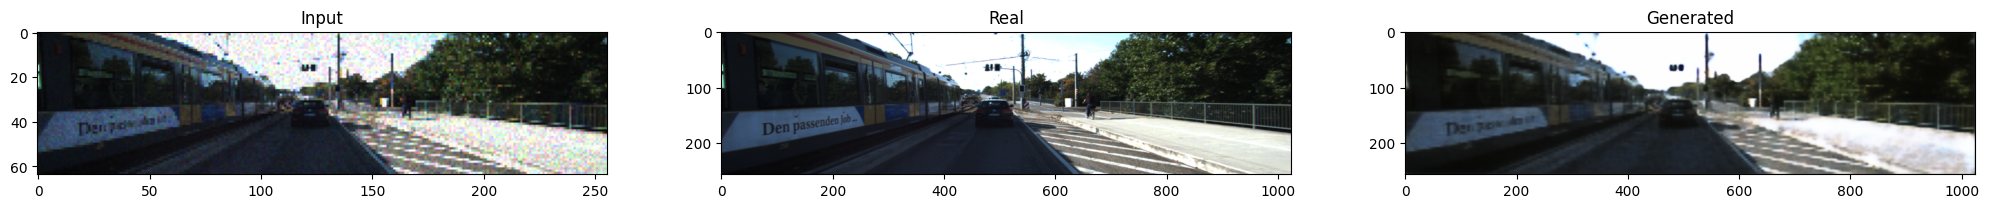

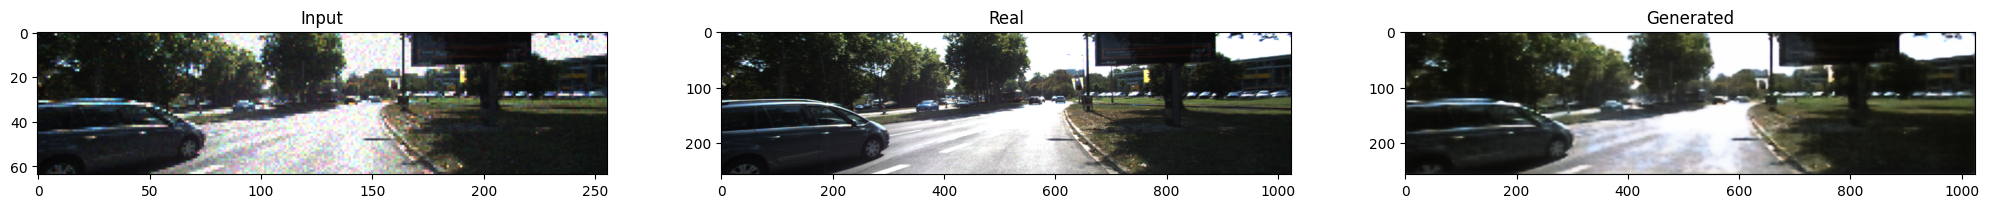

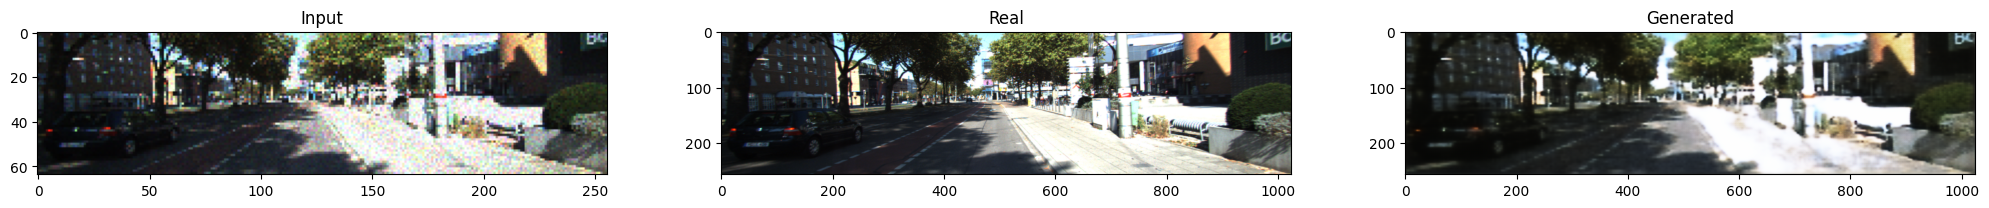

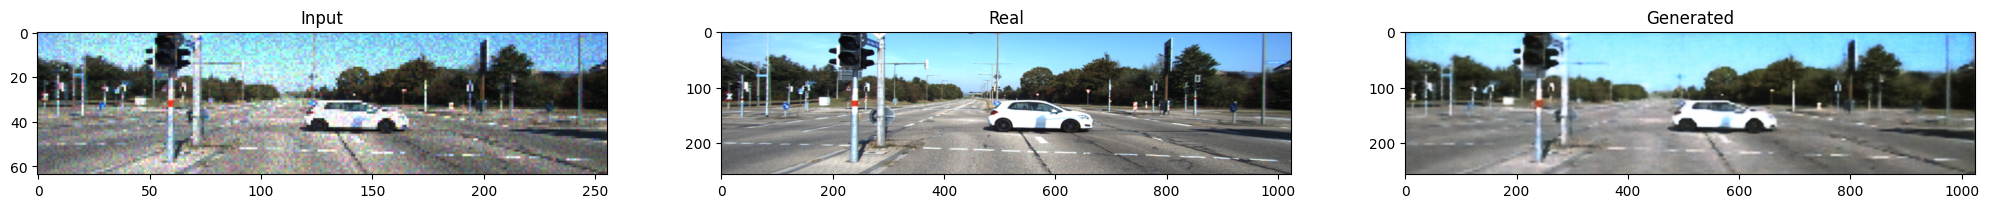

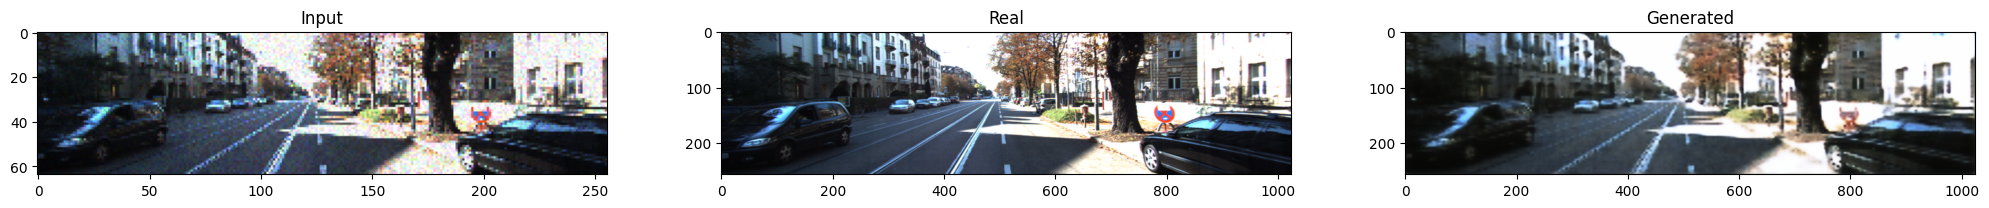

In [ ]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr, is_fake_lr=False)

Saving Noisy-image-Gaussian-noise-with-mean-and-variance-0005.png to Noisy-image-Gaussian-noise-with-mean-and-variance-0005 (5).png


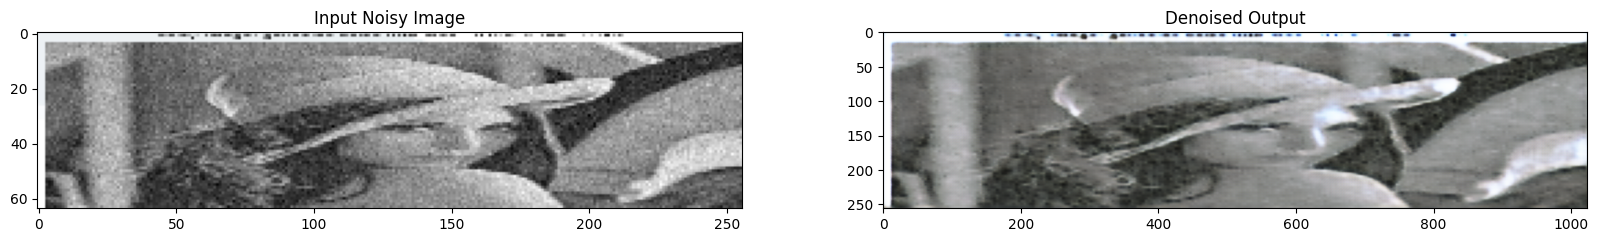

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def process_single_image(image_path, model):
    """
    Process a single noisy image and return the denoised result

    Parameters:
    -----------
    image_path : str
        Path to the input noisy image
    model : tensorflow.keras.Model
        Trained generator model

    Returns:
    --------
    None (displays the input and output images)
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)

    # Resize to low resolution dimensions
    image = tf.image.resize(image, size=(64, 256))
    image = tf.cast(image, dtype=tf.float32)

    # Normalize the image
    image = (image / 127.5) - 1

    # Add batch dimension
    image = tf.expand_dims(image, 0)

    # Generate output using the model
    fake_lr, fake_hr = model(image)  # Removed training argument

    # Display results
    plt.figure(figsize=(20, 10))

    # Display input image
    plt.subplot(1, 2, 1)
    plt.title('Input Noisy Image')
    plt.imshow(tf.squeeze(image) * 0.5 + 0.5)

    # Display denoised output
    plt.subplot(1, 2, 2)
    plt.title('Denoised Output')
    plt.imshow(tf.squeeze(fake_hr) * 0.5 + 0.5)

    plt.show()

    return fake_hr

# Example usage (with both options for getting the image)
def process_image():
    # Option 1: For image in Google Drive
    # image_path = "/content/drive/MyDrive/your_image.png"
    # denoised_image = process_single_image(image_path, generator)

    # Option 2: For uploading image directly in Colab
    from google.colab import files
    uploaded = files.upload()
    image_path = next(iter(uploaded))
    denoised_image = process_single_image(image_path, generator)
    return denoised_image

# Call this function to process your image
denoised_result = process_image()